## Loan Default Prediction

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:. 1) willingness to pay and 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

Given the above I want to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

In [41]:
#### importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
warnings.filterwarnings("ignore")


In [3]:
##### Reading in the data
demos= pd.read_csv('LoanPredict/traindemographics.csv')
perf = pd.read_csv('LoanPredict/trainperf.csv')
prevloans = pd.read_csv('LoanPredict/trainprevloans.csv')


##### a)Demographic data (traindemographics.csv)

1. customerid (Primary key used to merge to other data)
2. birthdate (date of birth of the customer)
3. bank_account_type (type of primary bank account)
4. longitude_gps
5. latitude_gps
6. bank_name_clients (name of the bank)
7. bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
8. employment_status_clients (type of employment that customer has)
9. level_of_education_clients (highest level of education)
##### b) Performance data (trainperf.csv) : This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer.

1. customerid (Primary key used to merge to other data)
2. systemloanid (The id associated with the particular loan. The same customerId can have multiple 3. 3. systemloanid’s for each loan he/she has taken out)
4. loannumber (The number of the loan that you have to predict)
5. approveddate (Date that loan was approved)
6. creationdate (Date that loan application was created)
7. loanamount (Loan value taken)
8. totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
9. termdays (Term of loan)
10. referredby (customerId of the customer that referred this person - is missing, then not referred)
11. good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict
##### c) Previous loans data (trainprevloans.csv) : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

1. customerid (Primary key used to merge to other data)
2. systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
3. loannumber (The number of the loan that you have to predict)
4. approveddate (Date that loan was approved)
5. creationdate (Date that loan application was created)
6. loanamount (Date that loan application was created)
7. totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
8. closeddate (Date that the loan was settled)
9. referredby (customerId of the customer that referred this person - is missing, then not refrerred)
10. firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
11. firstrepaiddate (Actual date that he/she paid the first payment as defined above)

In [8]:
# checking data structure
demos = pd.DataFrame(demos)
demos.head(5)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [9]:
# checking data structure
perf = pd.DataFrame(perf)
perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [10]:
# checking data structure
prevloans = pd.DataFrame(prevloans)
prevloans.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


##### Understanding the data and its structure

In [14]:
demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
customerid                    4346 non-null object
birthdate                     4346 non-null object
bank_account_type             4346 non-null object
longitude_gps                 4346 non-null float64
latitude_gps                  4346 non-null float64
bank_name_clients             4346 non-null object
bank_branch_clients           51 non-null object
employment_status_clients     3698 non-null object
level_of_education_clients    587 non-null object
dtypes: float64(2), object(7)
memory usage: 305.7+ KB


In [8]:
demos['level_of_education_clients'].unique()

array([nan, 'Secondary', 'Graduate', 'Post-Graduate', 'Primary'],
      dtype=object)

In [4]:
demos['bank_account_type'].unique()

array(['Savings', 'Other', 'Current'], dtype=object)

In [5]:
demos['employment_status_clients'].unique()

array([nan, 'Permanent', 'Student', 'Self-Employed', 'Unemployed',
       'Retired', 'Contract'], dtype=object)

In [6]:
perf.drop(['referredby'], axis=1)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,Good
5,8a8589f35451855401546b0738c42524,301986516,8,2017-07-19 21:46:24.000000,2017-07-19 20:46:18.000000,30000.0,39000.0,60,Good
6,8a858e095c59b91b015c5e5cea3719bc,301972027,3,2017-07-10 19:25:33.000000,2017-07-10 18:25:28.000000,10000.0,13000.0,30,Good
7,8a858e1158dc4d830158f7bde4f47ea7,301994428,10,2017-07-24 23:42:27.000000,2017-07-24 22:42:21.000000,30000.0,34500.0,30,Good
8,8a858e185b4923b4015b4ae48d28646a,301996687,4,2017-07-26 10:53:05.000000,2017-07-26 09:52:57.000000,10000.0,11500.0,15,Good
9,8a858e1d5cd58f9e015ceda4bdb63673,301981931,2,2017-07-17 13:48:42.000000,2017-07-17 12:48:35.000000,10000.0,11500.0,15,Good


##### Data exploration

In [17]:
prevloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
customerid         18183 non-null object
systemloanid       18183 non-null int64
loannumber         18183 non-null int64
approveddate       18183 non-null object
creationdate       18183 non-null object
loanamount         18183 non-null float64
totaldue           18183 non-null float64
termdays           18183 non-null int64
closeddate         18183 non-null object
referredby         1026 non-null object
firstduedate       18183 non-null object
firstrepaiddate    18183 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [7]:
prevloans.drop(['referredby'], axis=1)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000
5,8a858970548359cc0154883481981866,301832407,5,2017-03-06 13:25:17.000000,2017-03-06 12:25:10.000000,20000.0,23800.0,30,2017-04-04 15:46:56.000000,2017-04-05 00:00:00.000000,2017-04-04 15:31:47.000000
6,8a858970548359cc0154883481981866,301926513,8,2017-06-04 01:00:23.000000,2017-06-04 00:00:16.000000,30000.0,39000.0,60,2017-07-03 23:35:38.000000,2017-07-04 00:00:00.000000,2017-07-03 23:25:29.000000
7,8a8589f35451855401546b0738c42524,301912443,6,2017-05-18 09:42:18.000000,2017-05-18 08:41:12.000000,20000.0,24500.0,30,2017-06-19 10:10:35.000000,2017-06-19 00:00:00.000000,2017-06-19 10:00:21.000000
8,8a858e095c59b91b015c5e5cea3719bc,301936857,2,2017-06-13 08:26:31.000000,2017-06-13 07:26:24.000000,10000.0,13000.0,30,2017-07-10 13:32:03.000000,2017-07-13 00:00:00.000000,2017-07-10 13:21:53.000000
9,8a858e1158dc4d830158f7bde4f47ea7,301811291,3,2017-02-06 18:55:30.000000,2017-02-06 17:55:20.000000,10000.0,11500.0,15,2017-02-21 05:34:20.000000,2017-02-21 00:00:00.000000,2017-02-21 05:19:09.000000


In [22]:
perf.describe()

,systemloanid,loannumber,loanamount,totaldue,termdays
count,4.368000e+03,4368.000000,4368.000000,4368.000000,4368.000000
mean,3.019810e+08,5.172390,17809.065934,21257.377679,29.261676
std,1.343115e+04,3.653569,10749.694571,11943.510416,11.512519
min,3.019585e+08,2.000000,10000.000000,10000.000000,15.000000
25%,3.019691e+08,2.000000,10000.000000,13000.000000,30.000000
50%,3.019801e+08,4.000000,10000.000000,13000.000000,30.000000
75%,3.019935e+08,7.000000,20000.000000,24500.000000,30.000000
max,3.020040e+08,27.000000,60000.000000,68100.000000,90.000000


In [23]:
prevloans.describe()

,systemloanid,loannumber,loanamount,totaldue,termdays
count,1.818300e+04,18183.000000,18183.000000,18183.000000,18183.000000
mean,3.018395e+08,4.189353,16501.237420,19573.202931,26.692790
std,9.367767e+04,3.249490,9320.547516,10454.245277,10.946556
min,3.016001e+08,1.000000,3000.000000,3450.000000,15.000000
25%,3.017766e+08,2.000000,10000.000000,11500.000000,15.000000
50%,3.018550e+08,3.000000,10000.000000,13000.000000,30.000000
75%,3.019197e+08,6.000000,20000.000000,24500.000000,30.000000
max,3.020003e+08,26.000000,60000.000000,68100.000000,90.000000


In [24]:
# check the sum of the null values for each feature
prevloans.isnull().sum()

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64

In [25]:
# check the sum of the null values for each feature
perf.isnull().sum()

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

In [26]:
demos.isnull().sum()

customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4295
employment_status_clients      648
level_of_education_clients    3759
dtype: int64

##### Predict variable (desired target): 
good_bad_flag— is the client going to pay the borrowed loan? (binary: “1”, means “Yes”, “0” means “No”)

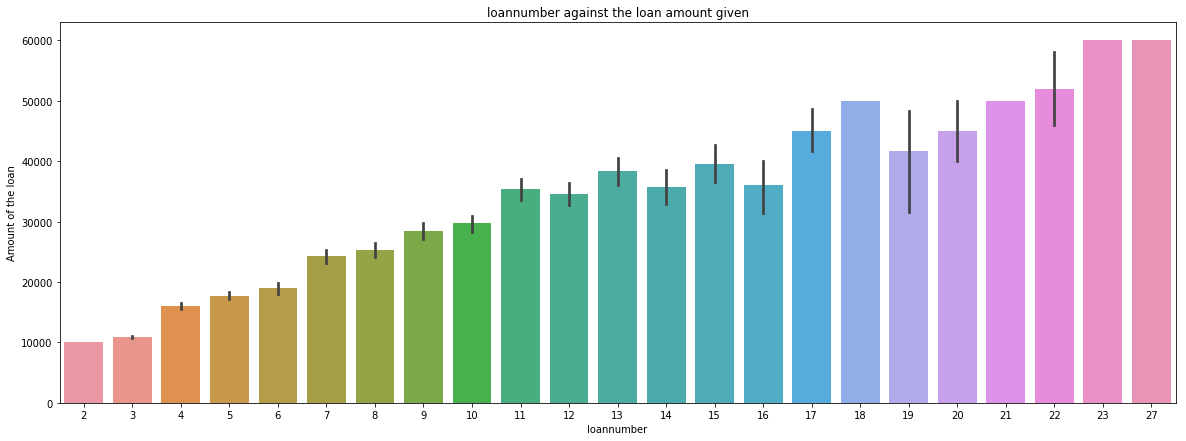

In [49]:
# demos = pd.DataFrame(demos['birthdate'].value_counts())
# demos.reset_index(inplace=True)
# demos.columns = [ 'birthdate']
# perf.columns = ['loanamount']

# demos=pd.DataFrame(demos)
# demos
# perf =pd.DataFrame(perf)
# perf
plt.figure(figsize=(20, 7))
barplot = sns.barplot( x = perf['loannumber'], y = perf['loanamount'])
barplot.set(xlabel='loannumber', ylabel='Amount of the loan')
plt.title("loannumber against the loan amount given")
plt.xlabel("loannumber")
plt.ylabel("Amount of the loan")
plt.show()

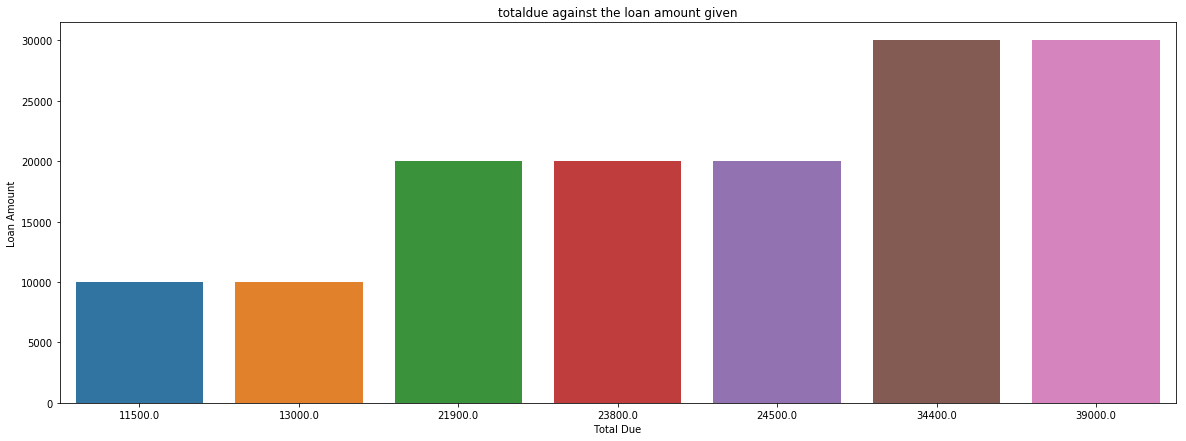

In [51]:
plt.figure(figsize=(20, 7))
barplot = sns.barplot( x = prevloans['totaldue'][:20], y = prevloans['loanamount'][:20])
barplot.set(xlabel='totaldue', ylabel='loanamount')
plt.title("totaldue against the loan amount given")
plt.xlabel("Total Due")
plt.ylabel("Loan Amount")
plt.show()

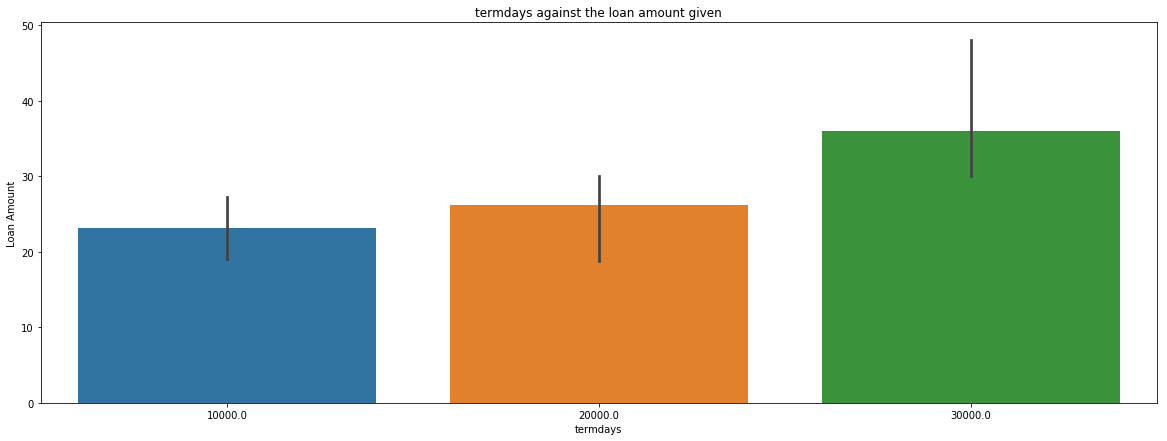

In [53]:
plt.figure(figsize=(20, 7))
barplot = sns.barplot( x = prevloans['loanamount'][:20], y = prevloans['termdays'][:20])
barplot.set(xlabel='termdays', ylabel='loanamount')
plt.title("termdays against the loan amount given")
plt.xlabel("termdays")
plt.ylabel("Loan Amount")

plt.show()

Employement status agaist the total given

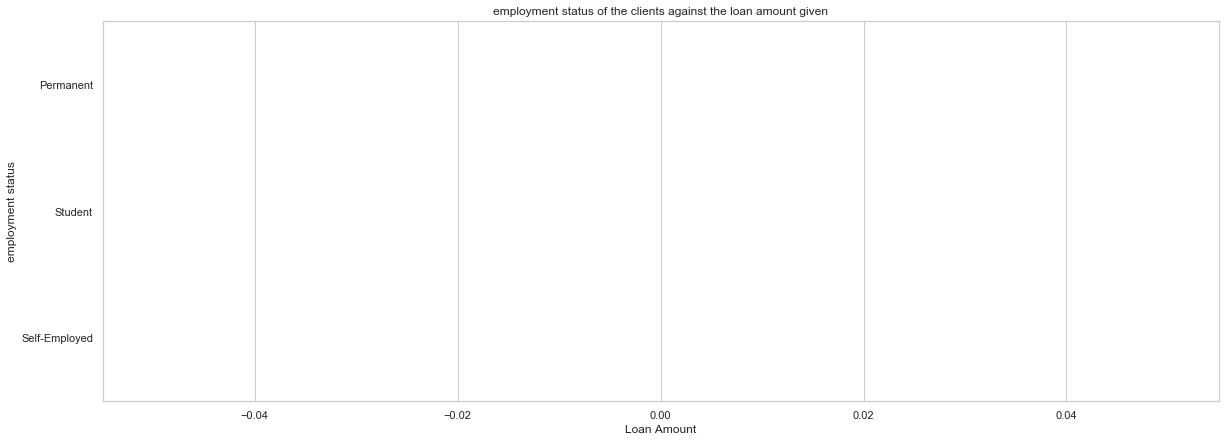

In [22]:
plt.figure(figsize=(20, 7))
barplot = sns.barplot( x = prevloans['loanamount'][:20].value_counts(), y = demos['employment_status_clients'][:20])
barplot.set(xlabel='employment_status_clients', ylabel='loanamount')
plt.title("employment status of the clients against the loan amount given")
plt.xlabel("Loan Amount")
plt.ylabel("employment status")

plt.show()

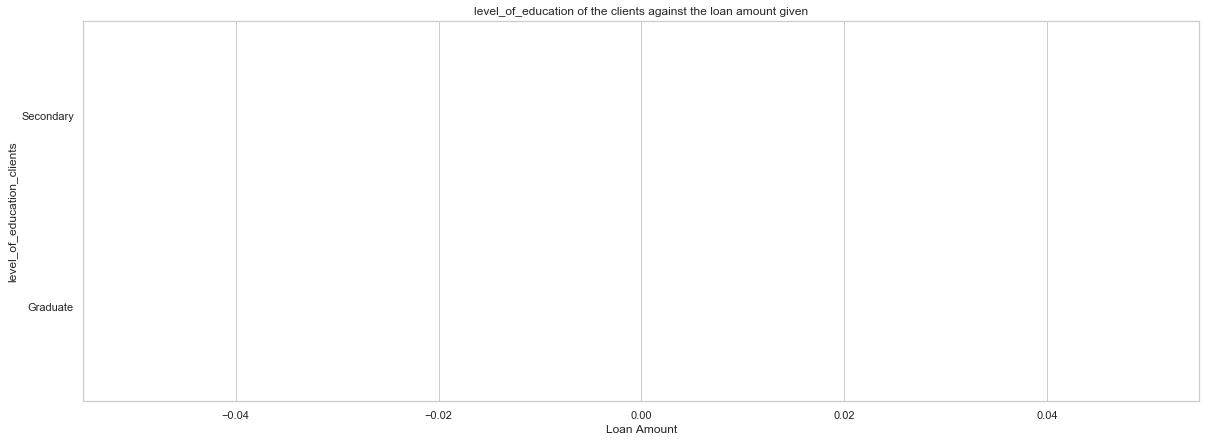

In [21]:
plt.figure(figsize=(20, 7))
barplot = sns.barplot( x = prevloans['loanamount'][:20].value_counts(), y = demos['level_of_education_clients'][:20])
barplot.set(xlabel='level_of_education_clients', ylabel='loanamount')
plt.title("level_of_education of the clients against the loan amount given")
plt.xlabel("Loan Amount")
plt.ylabel("level_of_education_clients")

plt.show()

In [14]:
perf['good_bad_flag'].value_counts()

Good    3416
Bad      952
Name: good_bad_flag, dtype: int64

Changing good to 1 and bad to 0 for the purpose of predictions on the good_bad_flag column

In [115]:
perf['good_bad_flag']=np.where(perf['good_bad_flag'] =='Good', '1', perf['good_bad_flag'])
perf['good_bad_flag']=np.where(perf['good_bad_flag'] =='Bad', '0', perf['good_bad_flag'])

In [116]:
perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,1
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,1
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,1
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,1
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,1


In [117]:
perf['good_bad_flag'].value_counts()

1    3416
0     952
Name: good_bad_flag, dtype: int64

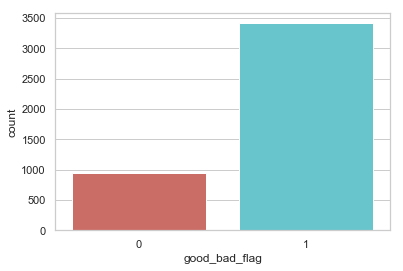

In [25]:
sns.countplot(x='good_bad_flag', data=perf, palette='hls')
plt.show()

In [ ]:
amount_due =  perf['totaldue']
pay_duration = perf['termdays']
pay_per_day = amount_due/pay_duration


In [134]:
# perf_zero= (perf['good_bad_flag']=='0').sum()
# print(perf_zero)
count_no_pay = (perf['good_bad_flag']=='0').sum()
count_pay = (perf['good_bad_flag']=='1').sum()
pct_of_no_pay = count_no_pay/(count_no_pay+count_pay)
print("percentage of no pay of the loan is", pct_of_no_pay*100)
pct_of_pay = count_pay/(count_no_pay+count_pay)
print("percentage of those that paid", pct_of_pay*100)

percentage of no pay of the loan is 21.794871794871796
percentage of those that paid 78.2051282051282
